# Chapter 4: Geocentric Models - Samples

In [1]:
from scipy import stats
from matplotlib import pyplot as plt
import pathlib
import pandas as pd
import numpy as np
import arviz as az
from scipy.interpolate import griddata
import pymc as pm
from patsy import dmatrix

**4E1** In the model definition below, which line is the likelihood?

$$y_i \sim \text{Normal}(\mu, \sigma)$$
$$\mu \sim \text{Normal}(0, 10)$$
$$\sigma \sim \text{Exponential}(1)$$

Answer:

The line is $y_i \sim \text{Normal}(\mu, \sigma)$

**4E2** In the model definition just above, how many parameters are in the posterior distribution?

Answer:

2

**4E3** Using the model definition above, write down the appropriate form of Bayes' theorem that includes the proper likelihood and priors.

Answer:

$$\text{Pr}(\mu, \sigma|D) = \frac{\prod_i \text{Normal} (D|\mu, \sigma) \text{Normal} (\mu|0, 10) \text{Exponential} (\sigma|1) }{\int \int \prod_i \text{Normal} (D|\mu, \sigma) \text{Normal} (\mu|0, 10) \text{Exponential} (\sigma|1) d\mu d\sigma}$$

**4E4** In the model definition below, which line is the linear model?

$$y_i \sim \text{Normal}(\mu, \sigma)$$
$$\mu_i = \alpha + \beta x_i$$
$$\alpha \sim \text{Normal}(0, 10)$$
$$\beta \sim \text{Normal}(0, 1)$$
$$\sigma \sim \text{Exponential}(2)$$

Answer:

The line is $\mu_i = \alpha + \beta x_i$

**4E5** In the model definition just above, how many parameters are in the posterior distribution?

Answer:

3

**4M1** For the model definition below, simulate observed $y$ values from the prior (not the posterior).

$$y_i \sim \text{Normal}(\mu, \sigma)$$
$$\mu \sim \text{Normal}(0, 10)$$
$$\sigma \sim \text{Exponential}(1)$$

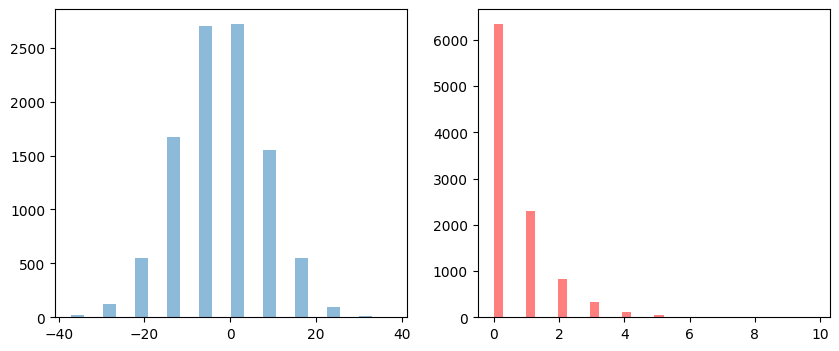

In [2]:
mu = np.random.normal(loc=0, scale=10, size=10_000)
sigma = np.random.exponential(scale=1, size=10_000)
plt.figure(figsize=(10,4))
plt.subplot(1, 2, 1)
plt.hist(mu, width=3, alpha=0.5)
plt.subplot(1, 2, 2)
plt.hist(sigma, width=0.3, color='r', alpha=0.5);

**4M2** Translate the model just above into a `quap` formula.

In [3]:
with pm.Model() as m42:
    mu = pm.Normal('mu', mu=0, sigma=10)
    sigma = pm.Exponential("sigma", lam=1)
    height = pm.Normal('height', mu=mu, sigma=sigma)

**4M3** Translate the `quap` model formula below into a mathematical model definition.

```R
y ~ dnorm(mu, sigma),
mu <- a + b*x,
a ~ dnorm( 0, 10 ),
b ~ dunif( 0, 1 ),
sigma ~ dexp( 1 )
```

Answer:

$$y_i \sim \text{Normal}(\mu, \sigma)$$
$$\mu_i = \alpha + \beta x_i$$
$$\alpha \sim \text{Normal}(0, 10)$$
$$\beta \sim \text{Uniform}(0, 1)$$
$$\sigma \sim \text{Exponential}(1)$$

**4M4** A sample of students is measured for height each year for 3 years. After the third year, you want to fit a linear regression predicting height using year as a predictor. Write down the mathematical model definition for this regression, using any variable names and priors you choose. Be prepared to defend your choice of priors.

Answer:

$$y_i \sim \text{Normal}(\mu, \sigma)$$
$$\mu_i = \alpha + \beta(\text{year}_i - \bar{\text{year}})$$
$$\alpha \sim \text{Normal}(160, 20)$$
$$\beta \sim \text{Log-Normal}(0, 1)$$
$$\sigma \sim \text{Uniform}(0, 50)$$

**4M5** Now suppose I remind you that every student got taller each year. Does this information lead you to change your choice of priors? How?

Answer:

No, it doesn't. The Log-Normal already assumes a positive growth.

**4M6** Now suppose I tell you that the variance among heights for students of the same age is never more than 64cm. How does this lead you to revise your priors?

Answer:

$$\sigma \sim \text{Uniform}(0, 64)$$

**4M7** Refit model m4.3 from the chapter, but omit the mean weight xbar this time. Compare the new model's posterior to that of the original model. In particular, look at the variance among the parameters. What is different? Then compare the posterior predictions of both models.

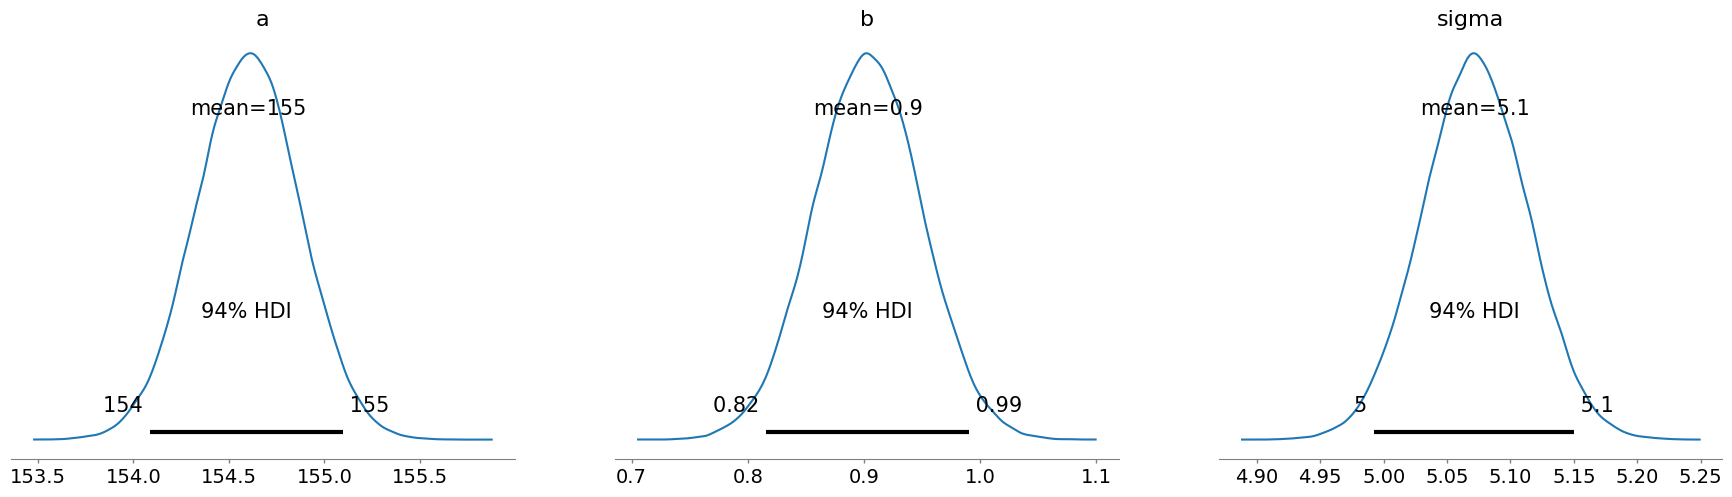

In [4]:
DATA_PATH = pathlib.Path('..') / '..' / 'data'

d = pd.read_csv(DATA_PATH.joinpath('Howell1.csv'), sep=';')
d2 = d[d['age'] >= 18]

# define the average weight, x-bar
xbar = d2['weight'].mean()

# fit model
with pm.Model() as m4_3:
    a = pm.Normal('a', mu=178, sigma=20)
    b = pm.LogNormal('b', mu=0, sigma=1)
    mu = a + b*(d2['weight'] - xbar)
    sigma = pm.Uniform("sigma", lower=0, upper=50)
    height = pm.Normal('height', mu=mu, sigma=sigma, observed=d2['height'].values)
    
mean_q = pm.find_MAP(model=m4_3)
H = pm.find_hessian(mean_q, model=m4_3)
cov = np.linalg.inv(H)
mean = np.concatenate([np.atleast_1d(mean_q[v.name]) for v in [a, b, sigma]])
posterior4_3 = stats.multivariate_normal(mean=mean, cov=cov)

samples = {}

samples_out = posterior4_3.rvs(size=100_000)
samples['a'] = samples_out[:, 0]
samples['b'] = samples_out[:, 1]
samples['sigma'] = samples_out[:, 2]
infer_data = az.convert_to_inference_data(samples)
az.plot_posterior(infer_data);

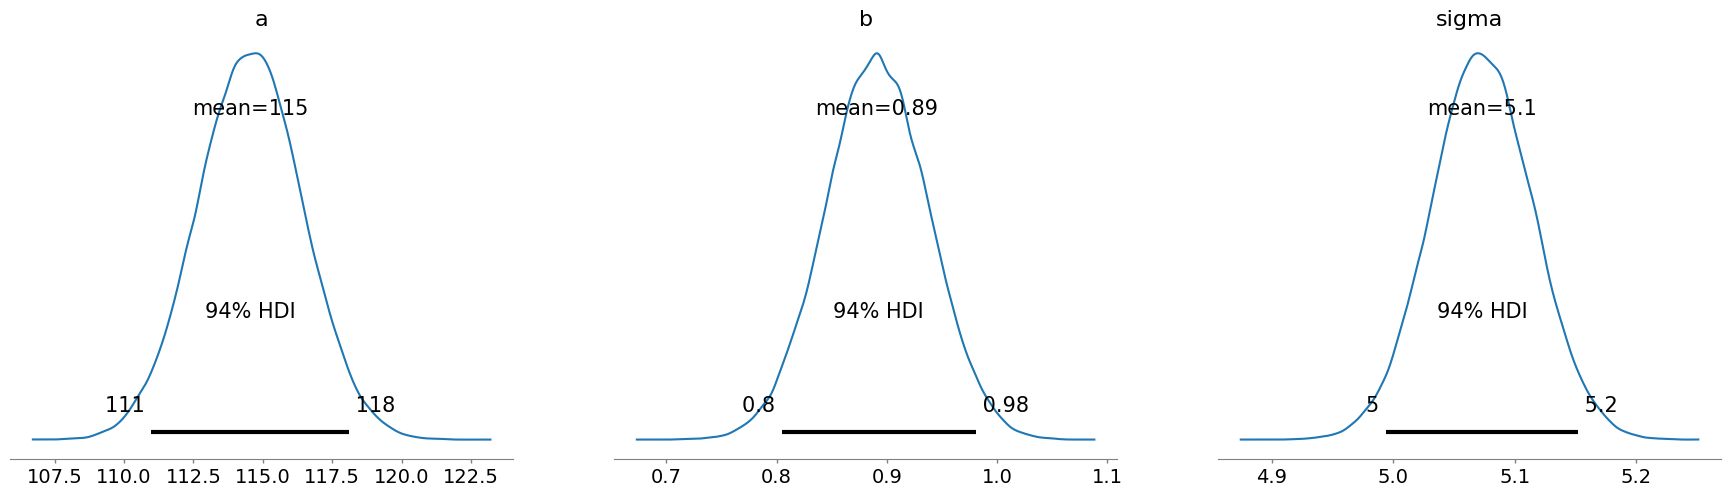

In [5]:
DATA_PATH = pathlib.Path('..') / '..' / 'data'

d = pd.read_csv(DATA_PATH.joinpath('Howell1.csv'), sep=';')
d2 = d[d['age'] >= 18]

# fit model
with pm.Model() as m4_3c:
    a = pm.Normal('a', mu=178, sigma=20)
    b = pm.LogNormal('b', mu=0, sigma=1)
    mu = a + b*d2['weight']
    sigma = pm.Uniform("sigma", lower=0, upper=50)
    height = pm.Normal('height', mu=mu, sigma=sigma, observed=d2['height'].values)
    
mean_q = pm.find_MAP(model=m4_3c)
H = pm.find_hessian(mean_q, model=m4_3c)
cov2 = np.linalg.inv(H)
mean = np.concatenate([np.atleast_1d(mean_q[v.name]) for v in [a, b, sigma]])
posterior4_3c = stats.multivariate_normal(mean=mean, cov=cov2)

samples = {}

samples_out = posterior4_3c.rvs(size=100_000)
samples['a'] = samples_out[:, 0]
samples['b'] = samples_out[:, 1]
samples['sigma'] = samples_out[:, 2]
infer_data = az.convert_to_inference_data(samples)
az.plot_posterior(infer_data);

In [6]:
with np.printoptions(precision=3, suppress=True):
    print('With xbar:\n {}'.format(cov.round(3)))
    print('Without xbar:\n {}'.format(cov2.round(3)))

With xbar:
 [[ 0.073 -0.     0.   ]
 [-0.     0.002 -0.   ]
 [ 0.    -0.     0.002]]
Without xbar:
 [[ 3.601 -0.088  0.002]
 [-0.088  0.002 -0.   ]
 [ 0.002 -0.     0.002]]


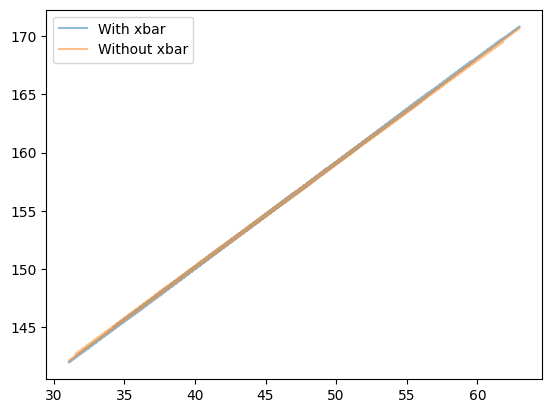

In [7]:
def sim(posterior, seq):
    post = posterior.rvs(size=10_000)
    weights_seq = np.tile(seq, (10_000, 1))
    mu = post[:, 0:1] + post[:, 1:2] * (seq - seq.mean())
    sigmas = np.tile(post[:, 2], (len(seq), 1)).T
    sim = np.random.normal(loc=mu, scale=sigmas, size=(10000, len(seq)))
    return sim

height_v1_mean = sim(posterior4_3, d2['weight'].values).mean(axis=0)

def sim(posterior, seq):
    post = posterior.rvs(size=10_000)
    weights_seq = np.tile(seq, (10_000, 1))
    mu = post[:, 0:1] + post[:, 1:2] * seq
    sigmas = np.tile(post[:, 2], (len(seq), 1)).T
    sim = np.random.normal(loc=mu, scale=sigmas, size=(10000, len(seq)))
    return sim

height_v2_mean = sim(posterior4_3c, d2['weight'].values).mean(axis=0)

plt.plot(d2['weight'], height_v1_mean, label='With xbar', alpha=0.5)
plt.plot(d2['weight'], height_v2_mean, label='Without xbar', alpha=0.5);
plt.legend();

**4M8** In the chapter, we used 15 knots with the cherry blossom spline. Increase the number of knots and observe what happens to the resulting spline. Then adjust also the width of the prior on the weights—change the standard deviation of the prior and watch what happens. What do you think the combination of knot number and the prior on the weights controls?

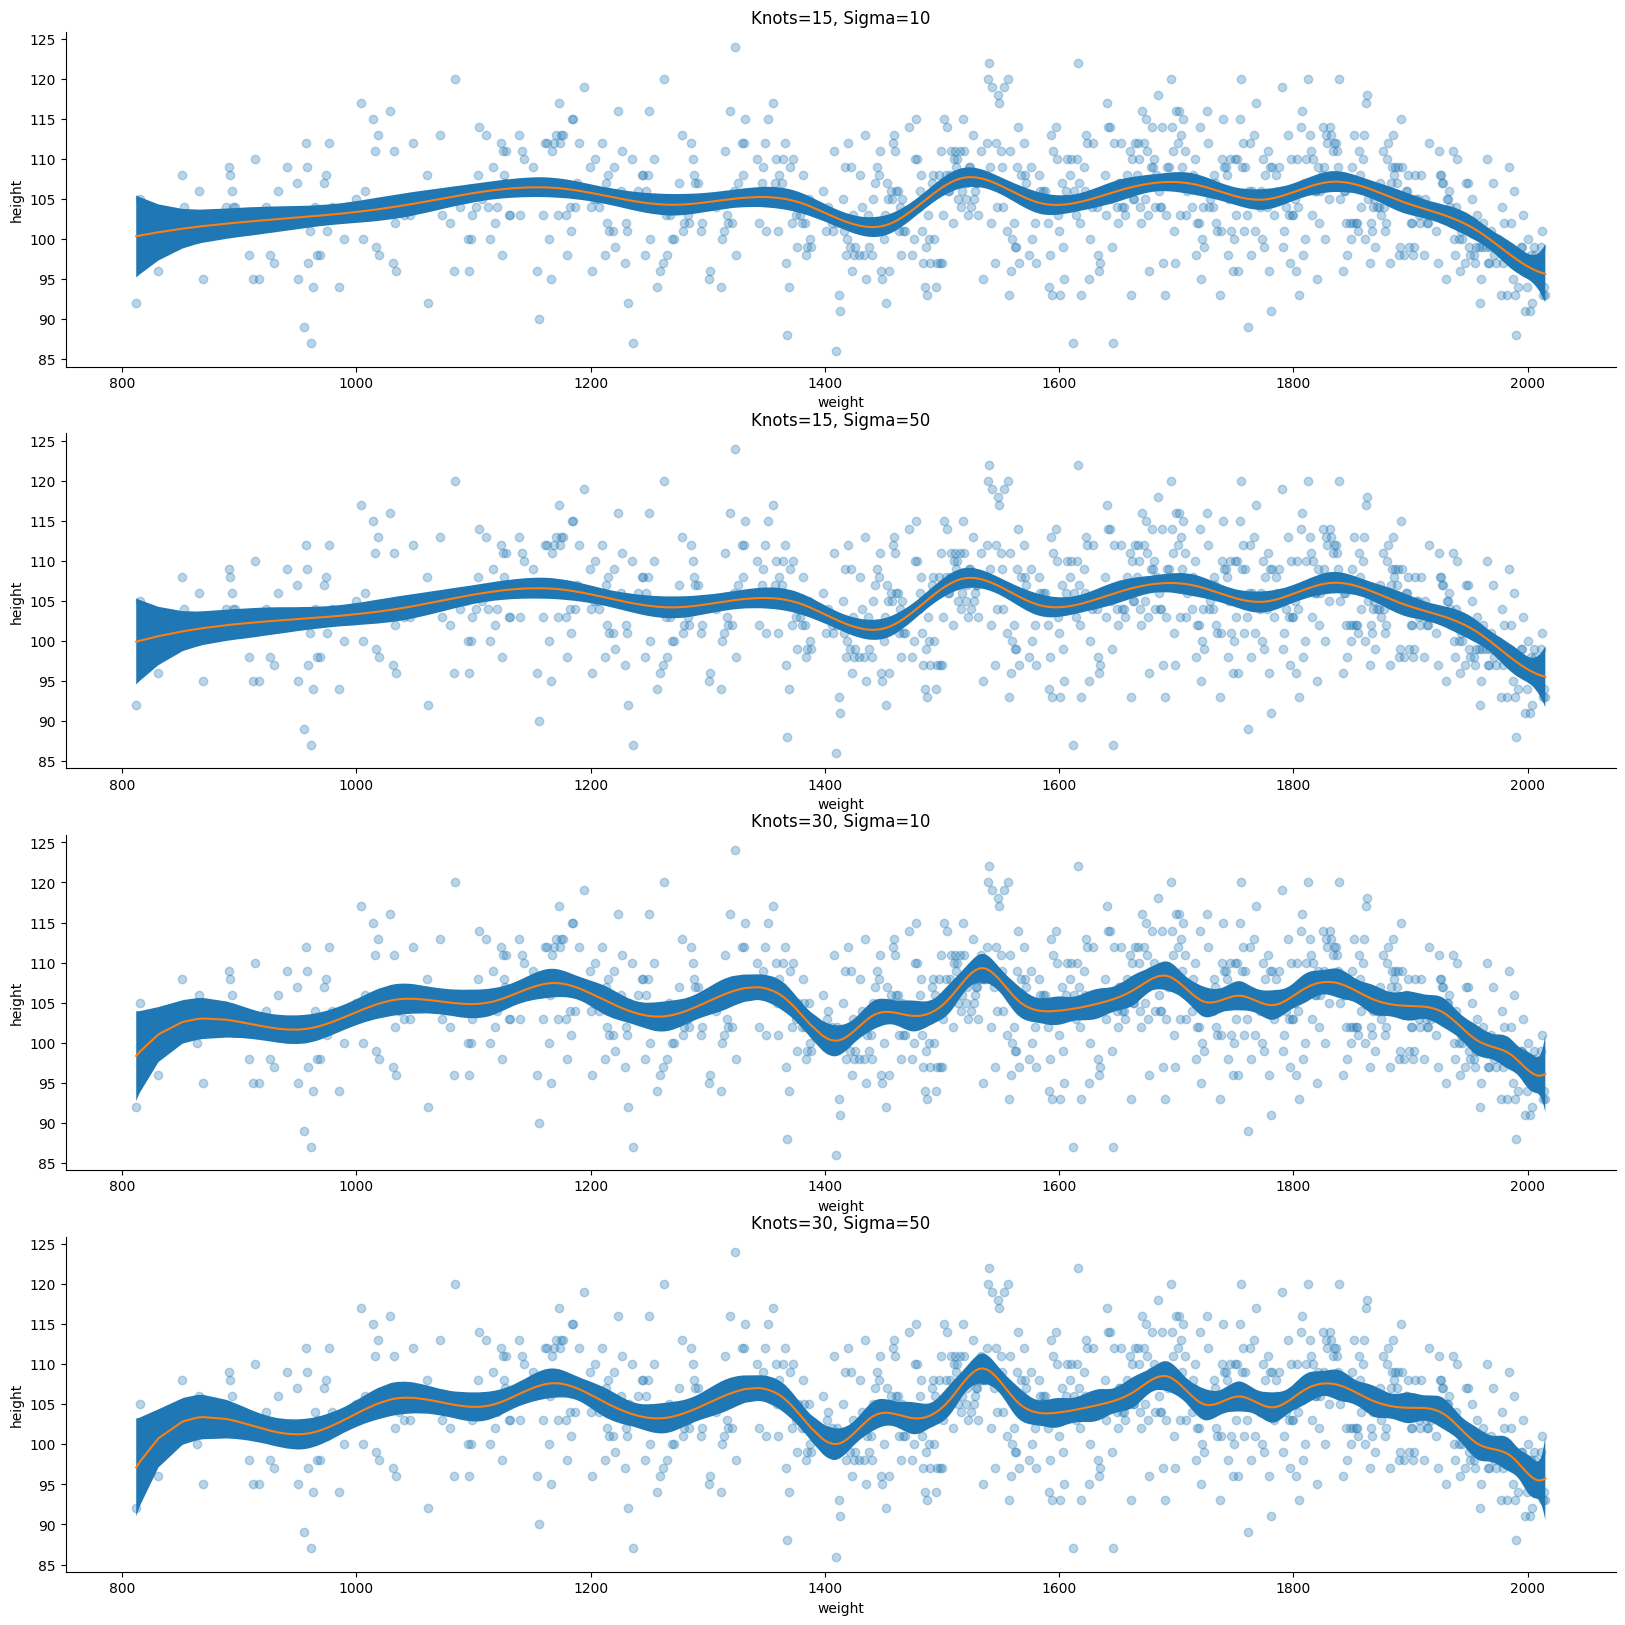

In [8]:
import itertools

d = pd.read_csv(DATA_PATH.joinpath('cherry_blossoms.csv'))
d2 = d.dropna(subset=['doy'])
_, axs = plt.subplots(4, 1, figsize=(20, 20))
axs = axs.flatten()

num_knots = [15, 30]
prior_sigma = [10, 50]

combinations = itertools.product(num_knots, prior_sigma)

for i, (num_knot, w_sigma) in enumerate(combinations):
    knot_list = np.quantile(d2['year'], np.linspace(0, 1, num_knot))

    # Generate B-Splines
    B = dmatrix(
        "bs(year, knots=knots, degree=3, include_intercept=True)-1",
        {"year": d2['year'].values, "knots": knot_list[1:-1]},
    )

    with pm.Model() as cherry_model:
        a = pm.Normal('a', 100, 10)
        w = pm.Normal('w', mu=0, sigma=w_sigma, shape=B.shape[1])
        mu = pm.Deterministic('mu', a + pm.math.dot(B.base, w.T))
        sigma = pm.Exponential('sigma', 1)
        D = pm.Normal('D', mu, sigma, observed=d2['doy'].values)

    mean_q = pm.find_MAP(model=cherry_model)
    H = pm.find_hessian(mean_q, model=cherry_model)
    cov = np.linalg.inv(H)
    mean = np.concatenate([np.atleast_1d(mean_q[v.name]) for v in [a, w, sigma]])
    posterior = stats.multivariate_normal(mean=mean, cov=cov)

    def link(posterior, seq):
        post = posterior.rvs(size=10_000)
        weights_seq = np.tile(seq, (10_000, 1))
        mu = post[:, 0:1] + np.dot(post[:, 1:-1], seq[:, :].T)
        return mu

    mu = link(posterior, B);
    mu_mean = mu.mean(axis=0)
    mu_pi = np.array([np.quantile(m, [0.055, 0.945]) for m in mu.T])

    axs[i].plot(d2['year'], d2['doy'], 'o', alpha=0.3)
    axs[i].plot(d2['year'], mu_mean)
    axs[i].fill_between(d2['year'], mu_pi[:, 0], mu_pi[:, 1])

    axs[i].spines.right.set_visible(False)
    axs[i].spines.top.set_visible(False)
    axs[i].set_xlabel('weight')
    axs[i].set_ylabel('height')
    axs[i].set_title(f'Knots={num_knot}, Sigma={w_sigma}');

By increasing the number of knots, the model fits even more to the data. While increasing the variation of the $\sigma$ prior, makes no difference.

**4H1** The weights listed below were recorded in the !Kung census, but the heights were not recorded for these individuals. Provide predicted heights and 89% intervals for each of these individuals. That is, fill in the table below, using model-based predictions.

|Individual|weight|expected height|89% interval|
|-|-|-|-|
|1|46.95|||
|2|43.72|||
|3|64.78|||
|4|32.59|||
|5|54.63|||

In [9]:
weights = np.array([46.95, 43.72, 64.78, 32.59, 54.63])
d = pd.read_csv(DATA_PATH.joinpath('Howell1.csv'), sep=';')
d2 = d[d['age'] >= 18]

# define the average weight, x-bar
xbar = d2['weight'].mean()

# fit model
with pm.Model() as m4_3:
    a = pm.Normal('a', mu=178, sigma=20)
    b = pm.LogNormal('b', mu=0, sigma=1)
    mu = a + b*(d2['weight'] - xbar)
    sigma = pm.Uniform("sigma", lower=0, upper=50)
    height = pm.Normal('height', mu=mu, sigma=sigma, observed=d2['height'].values)
    
mean_q = pm.find_MAP(model=m4_3)
H = pm.find_hessian(mean_q, model=m4_3)
cov = np.linalg.inv(H)
mean = np.concatenate([np.atleast_1d(mean_q[v.name]) for v in [a, b, sigma]])
posterior4_3 = stats.multivariate_normal(mean=mean, cov=cov)

def sim(posterior, seq):
    post = posterior.rvs(size=10_000)
    weights_seq = np.tile(seq, (10_000, 1))
    mu = post[:, 0:1] + post[:, 1:2] * (seq - d2['weight'].mean())
    sigmas = np.tile(post[:, 2], (len(seq), 1)).T
    sim = np.random.normal(loc=mu, scale=sigmas, size=(10000, len(seq)))
    return sim

heights = sim(posterior4_3, weights)
heights_mean = heights.mean(axis=0)
heights_hpdi = np.array([az.hdi(height_sample) for height_sample in heights])

for i in range(5):
    print(f'{i+1}\t{weights[i]}\t{heights_mean[i]:.2f}\t{heights_hpdi[i]}')


1	46.95	156.32	[141.5278616 177.1428606]
2	43.72	153.52	[144.82300139 173.79173821]
3	64.78	172.51	[144.60556832 175.17185852]
4	32.59	143.37	[136.23214377 168.67207412]
5	54.63	163.41	[140.81189857 175.90587841]


**4H2** Select out all the rows in the `Howell1` data with ages below 18 years of age. If you do it right, you should end up with a new data frame with 192 rows in it.

(a) Fit a linear regression to these data, using `quap`. Present and interpret the estimates. For every 10 units of increase in weight, how much taller does the model predict a child gets?

(b) Plot the raw data, with height on the vertical axis and weight on the horizontal axis. Superimpose the MAP regression line and 89% interval for the mean. Also superimpose the 89% interval for predicted heights.

(c) What aspects of the model fit concern you? Describe the kinds of assumptions you would change, if any, to improve the model. You don't have to write any new code. Just explain what the model appears to be doing a bad job of, and what you hypothesize would be a better model.

In [10]:
d3 = d[d['age'] < 18]
print(d3.shape)

(192, 4)


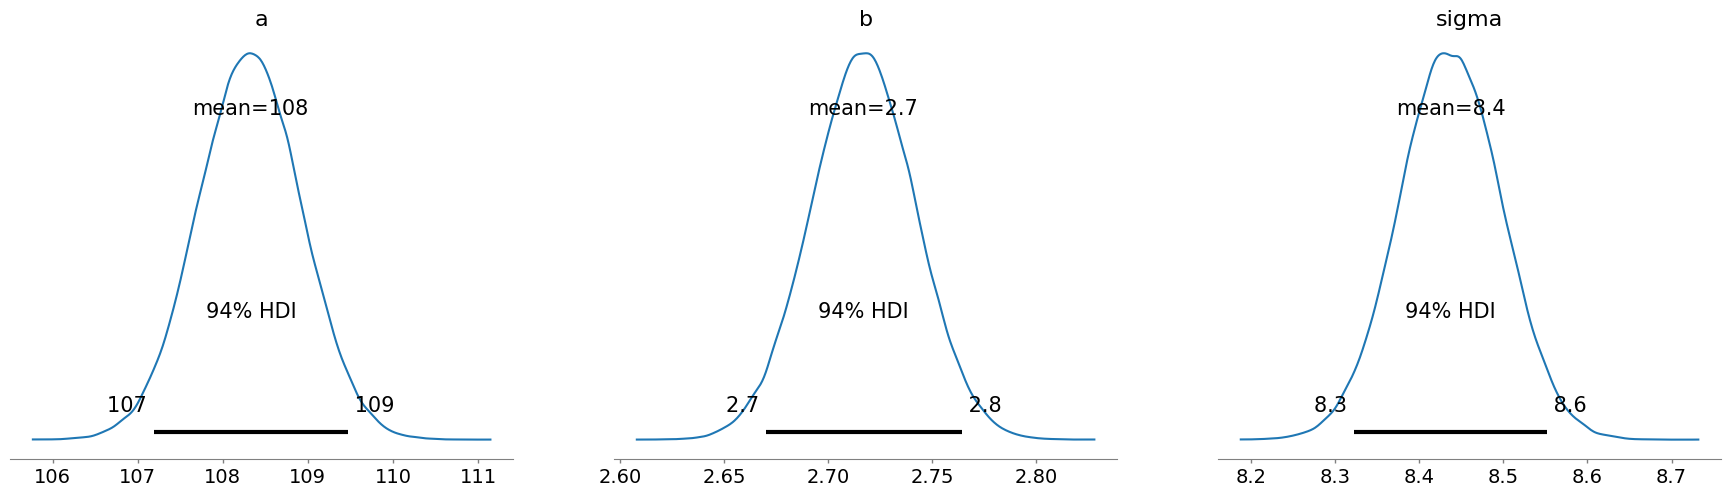

In [11]:
# Fit a linear regression with `quap`
xbar = d3['weight'].mean()
ybar = d3['height'].mean()

# fit model
with pm.Model() as young_heights:
    a = pm.Normal('a', mu=ybar, sigma=20)
    b = pm.LogNormal('b', mu=0, sigma=1)
    mu = a + b*(d3['weight'] - xbar)
    sigma = pm.Uniform("sigma", lower=0, upper=50)
    height = pm.Normal('height', mu=mu, sigma=sigma, observed=d3['height'].values)
    
mean_q = pm.find_MAP(model=young_heights)
H = pm.find_hessian(mean_q, model=young_heights)
cov = np.linalg.inv(H)
mean = np.concatenate([np.atleast_1d(mean_q[v.name]) for v in [a, b, sigma]])
posterior = stats.multivariate_normal(mean=mean, cov=cov)

samples = {}

samples_out = posterior.rvs(size=100_000)
samples['a'] = samples_out[:, 0]
samples['b'] = samples_out[:, 1]
samples['sigma'] = samples_out[:, 2]
infer_data = az.convert_to_inference_data(samples)
az.plot_posterior(infer_data);

In [12]:
b_mean = mean[1]
print(f'For every 10 kg of increase in weight, the model predicts an increase in {b_mean * 10:.2f} cm.')

For every 10 kg of increase in weight, the model predicts an increase in 27.17 cm.


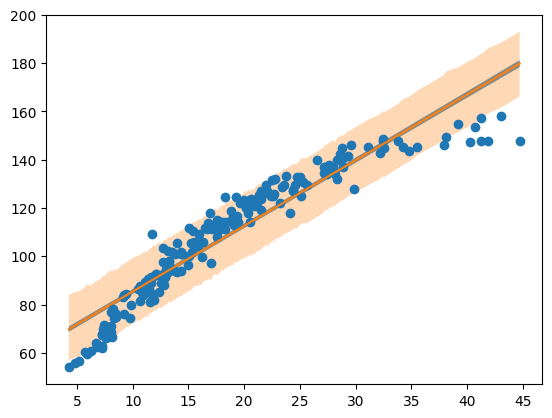

In [13]:
weights = d3['weight'].sort_values().values
weights_mean = d3['weight'].mean()

post = posterior.rvs(size=10_000)
weights_seq = np.tile(weights, (10_000, 1))
mu = post[:, 0:1] + post[:, 1:2] * (weights - weights_mean)
sigmas = np.tile(post[:, 2], (len(weights), 1)).T

heights = np.random.normal(loc=mu, scale=sigmas, size=(10000, len(weights)))
mu_mean = mu.mean(axis=0)
mu_hpdi = np.array([np.quantile(mu_row, [0.055, 0.945]) for mu_row in mu.T])
heights_hpdi = np.array([az.hdi(h, 0.89) for h in heights.T])

fig, ax = plt.subplots()
plt.plot(d3['weight'], d3['height'], 'o')
plt.plot(weights, mu_mean)
plt.fill_between(weights, mu_hpdi[:, 0], mu_hpdi[:, 1], alpha=0.8)
plt.fill_between(weights, heights_hpdi[:, 0], heights_hpdi[:, 1], alpha=0.3);

The model fit is assuming a stable growth, while children with more weight start stabilizing their own height. I would assume a polynomial growth would be a better fit and would add a quadratic parameter.

**4H3** Suppose a colleague of yours, who works on allometry, glances at the practice problems just above. Your colleague exclaims, "That's silly. Everyone knows that it's only the logarithm of body weight that scales with height!" Let's take your colleague's advice and see what happens.

(a) Model the relationship between height (cm) and the natural logarithm of weight (log-kg). Use the entire `Howell1` data frame, all 544 rows, adults and non-adults. Can you interpret the resulting estimates?

(b) Begin with this plot: `plot( height ~ weight, data=Howell1 )`. Then use samples from the quadratic approximate posterior of the model in (a) to superimpose on the plot: (1) the predicted mean height as a function of weight, (2) the 97% interval for the mean, and (3) the 97% interval for predicted heights.

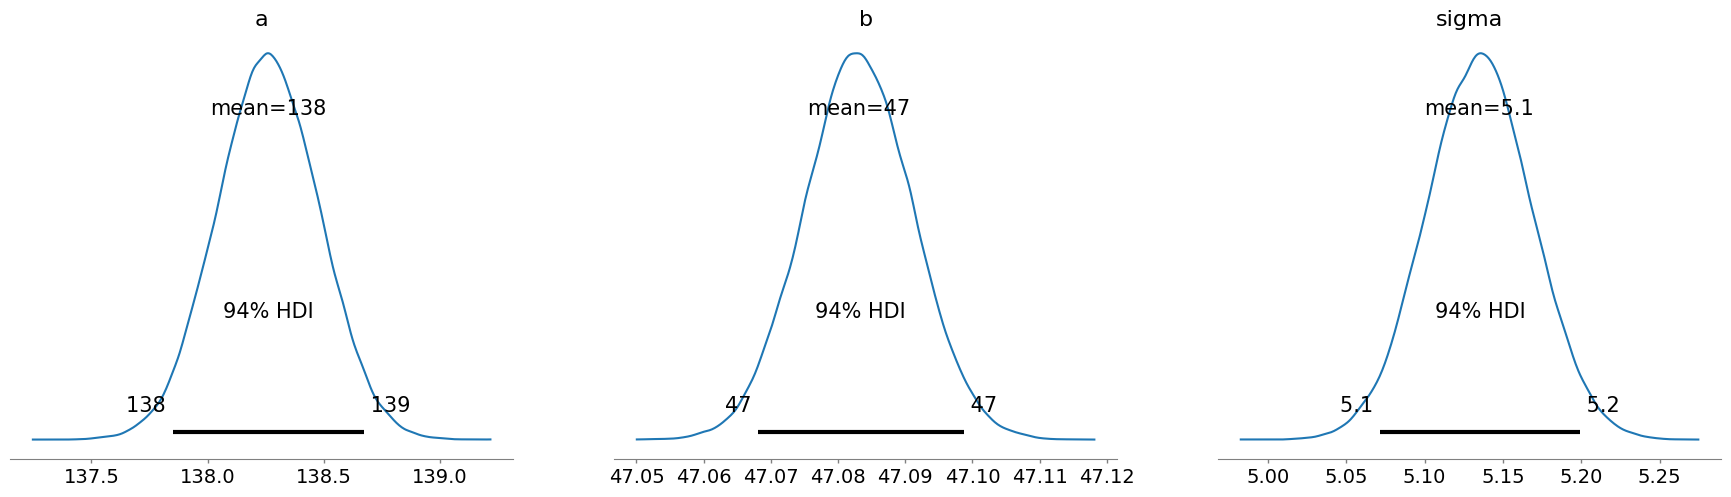

In [28]:
# Fit a linear regression with `quap`
log_weights = np.log(d['weight'])
xbar = log_weights.mean()


# fit model
with pm.Model() as all_heights:
    a = pm.Normal('a', mu=ybar, sigma=20)
    b = pm.LogNormal('b', mu=1, sigma=10)
    mu = a + b*(log_weights - xbar)
    sigma = pm.Uniform("sigma", lower=0, upper=50)
    height = pm.Normal('height', mu=mu, sigma=sigma, observed=d['height'].values)
    
mean_q = pm.find_MAP(model=all_heights)
H = pm.find_hessian(mean_q, model=all_heights)
cov = np.linalg.inv(H)
mean = np.concatenate([np.atleast_1d(mean_q[v.name]) for v in [a, b, sigma]])
posterior = stats.multivariate_normal(mean=mean, cov=cov)

samples = {}

samples_out = posterior.rvs(size=100_000)
samples['a'] = samples_out[:, 0]
samples['b'] = samples_out[:, 1]
samples['sigma'] = samples_out[:, 2]
infer_data = az.convert_to_inference_data(samples)
az.plot_posterior(infer_data);

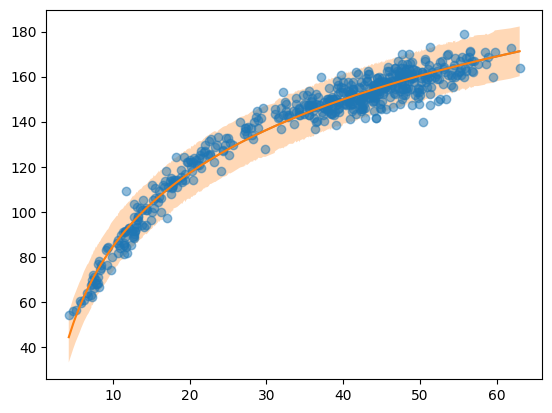

In [33]:
weights = np.log(d['weight'].sort_values())

post = posterior.rvs(size=10_000)
weights_seq = np.tile(weights, (10_000, 1))
mu = post[:, 0:1] + post[:, 1:2] * (weights_seq - xbar)
sigmas = np.tile(post[:, 2], (len(weights), 1)).T

heights = np.random.normal(loc=mu, scale=sigmas, size=(10000, len(weights)))
mu_mean = mu.mean(axis=0)
mu_hpdi = np.array([np.quantile(mu_row, [0.015, 0.985]) for mu_row in mu.T])
heights_hpdi = np.array([az.hdi(h, 0.97) for h in heights.T])

fig, ax = plt.subplots()
plt.plot(d['weight'], d['height'], 'o', alpha=0.5)
plt.plot(np.exp(weights), mu_mean)
plt.fill_between(np.exp(weights), mu_hpdi[:, 0], mu_hpdi[:, 1], alpha=0.8)
plt.fill_between(np.exp(weights), heights_hpdi[:, 0], heights_hpdi[:, 1], alpha=0.3);

**4H4** Plot the prior predictive distribution for the parabolic polynomial regression model in the chapter. You can modify the code that plots the linear regression prior predictive distribution. Can you modify the prior distributions of α, β1, and β2 so that the prior predictions stay within the biologically reasonable outcome space? That is to say: Do not try to fit the data by hand. But do try to keep the curves consistent with what you know about height and weight, before seeing these exact data.

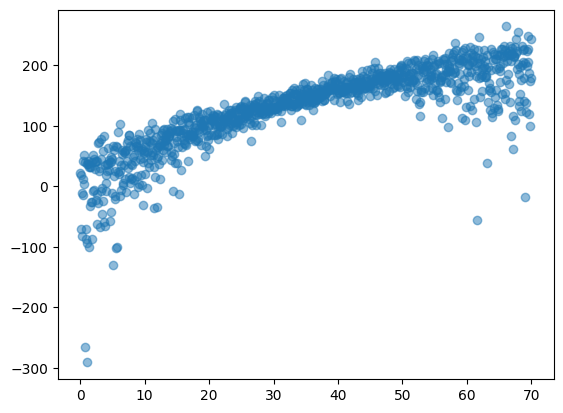

In [137]:
weights = np.linspace(0, 70, 1_000)
weights_s = (weights - weights.mean())
weights_s2 = weights_s**2

a = np.random.normal(150, 10, size=1_000)
b1 = np.random.lognormal(1, 0.10, size=1_000)
b2 = np.random.exponential(0.05, size=1_000)
mu = a + b1*weights_s - b2*weights_s2
sigma = np.random.uniform(0, 1, size=1_000)
height = np.random.normal(loc=mu, scale=sigma, size=1_000)
plt.plot(weights, height, 'o', alpha=0.5);

The main idea is that in the extremes we have different cases where people are overweight even if they are small and don't weight nothing as well.

**4H5** Return to `data(cherry_blossoms)` and model the association between blossom date `(doy)` and March temperature `(temp)`. Note that there are many missing values in both variables. You may consider a linear model, a polynomial, or a spline on temperature. How well does temperature trend predict the blossom trend?

In [143]:
d = pd.read_csv(DATA_PATH.joinpath('cherry_blossoms.csv'))
d2 = d.dropna(subset=['doy', 'temp'], how='any')

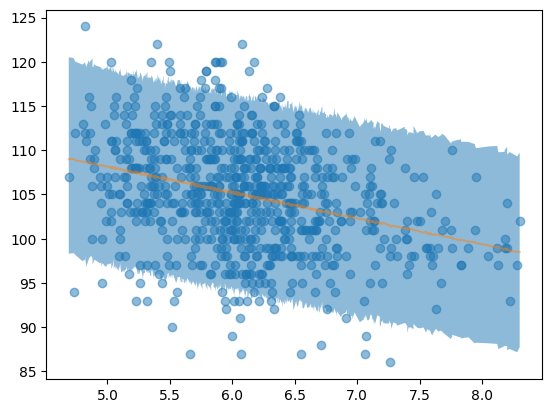

In [147]:
xbar = d2['temp'].mean()
with pm.Model() as temp_blossom:
    a = pm.Normal('a', mu=105, sigma=20)
    b = pm.LogNormal('b', mu=0, sigma=1)
    mu = a - b * (d2['temp'].values - xbar)
    sigma = pm.Uniform("sigma", lower=0, upper=50)
    height = pm.Normal('height', mu=mu, sigma=sigma, observed=d2['doy'].values)
    
mean_q = pm.find_MAP(model=temp_blossom)
H = pm.find_hessian(mean_q, model=temp_blossom)
cov = np.linalg.inv(H)
mean = np.concatenate([np.atleast_1d(mean_q[v.name]) for v in [a, b, sigma]])
posterior = stats.multivariate_normal(mean=mean, cov=cov)

temps = d2['temp'].sort_values().values
post = posterior.rvs(size=10_000)
temps_seq = np.tile(temps, (10_000, 1))
mu = post[:, 0:1] - post[:, 1:2] * (temps_seq - xbar)
sigmas = np.tile(post[:, 2], (len(temps), 1)).T
doy = np.random.normal(loc=mu, scale=sigmas, size=(10000, len(temps)))

mu_mean = mu.mean(axis=0)
doy_hpdi = np.array([az.hdi(dd) for dd in doy.T])
plt.plot(d['temp'], d['doy'], 'o', alpha=0.5);
plt.plot(temps, doy_mean, alpha=0.5)
plt.fill_between(temps, doy_hpdi[:, 0], doy_hpdi[:, 1], alpha=0.5);

**4H6** Simulate the prior and predictive distribution for the cherry blossom spline in the chapter. Adjust the prior on the weights and observe that happens. What do you think the prior on the weights is doing?

**4H8** The cherry blossom spline in the chapter used an intercept $\alpha$, but technically it doesn't require one. The first basis functions could substitute for the intercept. Try refitting the cherry blossom spline without the intercept. What else about the model do you need to change to make this work?